T1-only model loaded and set to evaluation mode on cpu
Test T1 volume shape: (240, 240, 155)
Inference complete. 3D segmentation mask generated.


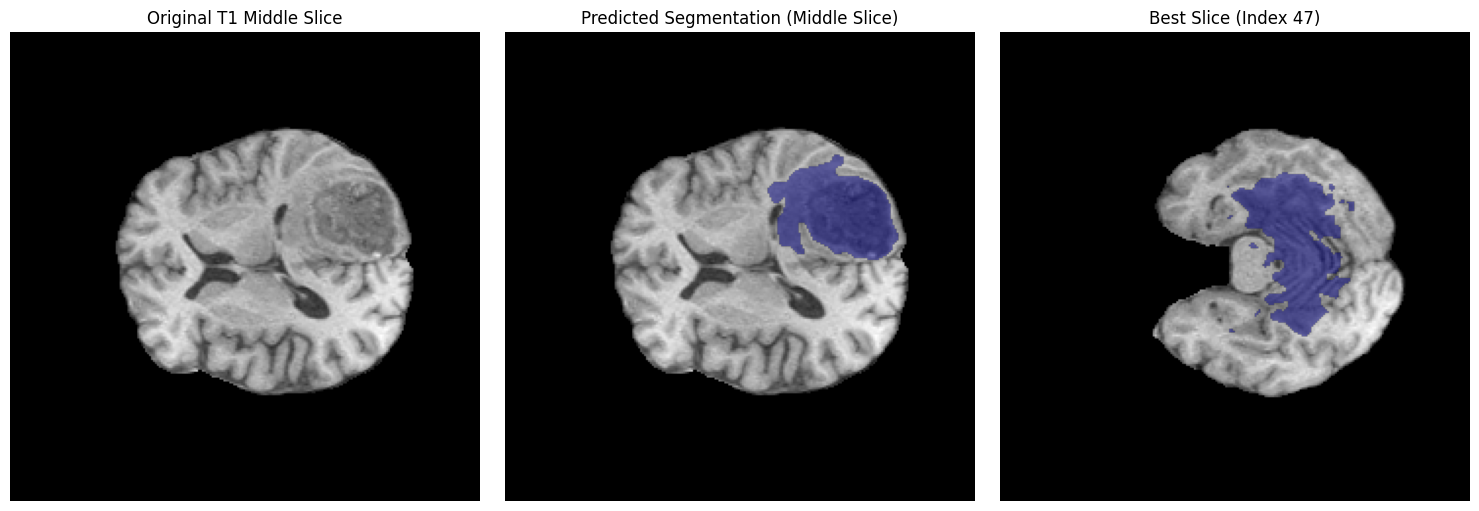

Maximum 2D tumour area: 2703.00 mm² (occurs at slice index 47)
Total 3D tumour volume: 123320.00 mm³
3D tumour reconstruction saved as STL at: C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\3D Model Files\t1_model_tumour_mesh.stl
Surface Area: 47386.33 mm²
Surface Area-to-Volume Ratio: 0.3843 mm⁻¹
Sphericity (Tumour Roundness): 0.2528 (1.0 indicates a perfect sphere)


In [ ]:
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import trimesh

# -------------------------------
# Step 1: Load the Saved T1-Only Model (TorchScript)
# -------------------------------
device = torch.device("cpu")  # Change to "cuda" if a GPU is available 
model_path = r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\web\backend\t1_attention_model_script.pt" 
model = torch.jit.load(model_path, map_location=device)
model.eval()
print("T1-only model loaded and set to evaluation mode on", device)

# -------------------------------
# Step 2: Load a Test T1 Volume
# -------------------------------
test_t1_path = r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\UPenn_GBM\images\UPENN-GBM-00145_11\UPENN-GBM-00145_11_T1.nii.gz" 
t1_nii = nib.load(test_t1_path)
t1_data = t1_nii.get_fdata()  # shape: [H, W, D]
H, W, D = t1_data.shape
print("Test T1 volume shape:", t1_data.shape)

# Extract voxel dimensions from the NIfTI header
voxel_dims = t1_nii.header.get_zooms()[:3]  # (x_spacing, y_spacing, z_spacing)
x_spacing, y_spacing, z_spacing = voxel_dims
pixel_area = x_spacing * y_spacing  # area in mm²

# -------------------------------
# Step 3: Run Inference on Each Slice to Generate a 3D Segmentation Mask
# -------------------------------
pred_volume = np.zeros((H, W, D), dtype=np.uint8)

# compute per-slice tumour areas for later analysis.
slice_areas = []

for i in range(D):
    slice_data = t1_data[:, :, i]
    
    # Normalize the slice to [0, 1]
    mn, mx = np.min(slice_data), np.max(slice_data)
    norm_slice = (slice_data - mn) / (mx - mn + 1e-8)
    
    # Prepare input tensor: shape [1, 1, H, W]
    input_tensor = torch.tensor(norm_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
    
    # Convert logits to probabilities and create a binary mask with threshold 0.5
    pred_probs = torch.sigmoid(output).cpu().numpy()[0, 0]
    pred_mask = (pred_probs > 0.5).astype(np.uint8)
    
    pred_volume[:, :, i] = pred_mask
    
    # Calculate the area for this slice (in mm²)
    tumour_pixels = np.sum(pred_mask)
    area_slice = tumour_pixels * pixel_area
    slice_areas.append(area_slice)

print("Inference complete. 3D segmentation mask generated.")

# -------------------------------
# Step 4: Visualization of Segmentation
# -------------------------------
# (A) Visualize the middle slice
middle_slice = D // 2
original_middle = t1_data[:, :, middle_slice]
pred_middle = pred_volume[:, :, middle_slice]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_middle, cmap='gray')
plt.title("Original T1 Middle Slice")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(original_middle, cmap='gray')
plt.imshow(np.ma.masked_where(pred_middle == 0, pred_middle), cmap='jet', alpha=0.5)
plt.title("Predicted Segmentation (Middle Slice)")
plt.axis("off")

# (B) Visualize the slice with the maximum tumour area
best_slice_index = np.argmax(slice_areas)
original_best = t1_data[:, :, best_slice_index]
pred_best = pred_volume[:, :, best_slice_index]

plt.subplot(1, 3, 3)
plt.imshow(original_best, cmap='gray')
plt.imshow(np.ma.masked_where(pred_best == 0, pred_best), cmap='jet', alpha=0.5)
plt.title(f"Best Slice (Index {best_slice_index})")
plt.axis("off")

plt.tight_layout()
plt.show()

# -------------------------------
# Step 5: Calculate Tumour Area and 3D Volume
# -------------------------------
total_volume = 0.0
for i in range(D):
    tumour_pixels = np.sum(pred_volume[:, :, i])
    area_slice = tumour_pixels * pixel_area  # in mm²
    total_volume += area_slice * z_spacing   # in mm³

max_area = max(slice_areas)
print(f"Maximum 2D tumour area: {max_area:.2f} mm² (occurs at slice index {best_slice_index})")
print(f"Total 3D tumour volume: {total_volume:.2f} mm³")

# ------------------------------------------------
# Step 6: 3D Reconstruction of the Tumour and Additional Metrics
# ------------------------------------------------

# Use marching cubes to extract a surface mesh from the 3D predicted mask.
verts, faces, normals, _ = measure.marching_cubes(pred_volume, level=0.5, spacing=voxel_dims)

# Create a trimesh object for the surface mesh.
mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)

# Save the 3D tumour reconstruction as an STL file.
stl_save_dir = r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\3D Model Files"
os.makedirs(stl_save_dir, exist_ok=True)
stl_save_path = os.path.join(stl_save_dir, "t1_model_tumour_mesh.stl")
if os.path.exists(stl_save_path):
    os.remove(stl_save_path)
mesh.export(stl_save_path)
print("3D tumour reconstruction saved as STL at:", stl_save_path)

# ------------------------------------------------
# Step 7: Compute Additional Metrics: Surface Area-to-Volume Ratio & Tumour Roundness
# ------------------------------------------------

# Get the surface area from the reconstructed mesh (in mm²)
surface_area = mesh.area  
# Compute Surface Area-to-Volume Ratio (units: mm²/mm³, which simplifies to 1/mm)
sa_to_volume_ratio = surface_area / total_volume

# Compute Sphericity (Tumour Roundness) using the formula:
# Sphericity = (π^(1/3) * (6 * Volume)^(2/3)) / Surface Area
sphericity = (np.pi**(1/3) * (6 * total_volume)**(2/3)) / surface_area

print(f"Surface Area: {surface_area:.2f} mm²")
print(f"Surface Area-to-Volume Ratio: {sa_to_volume_ratio:.4f} mm⁻¹")
print(f"Sphericity (Tumour Roundness): {sphericity:.4f} (1.0 indicates a perfect sphere)")